In [73]:
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import time

class AdvancedViz():

    def __init__(self, data_path = "../ift6758/data/tidy/all_seasons_combined.csv", rink_img = "../figures/nhl_rink.png"):
        self._data = pd.read_csv(data_path)
        self._rink_img = mpimg.imread(rink_img)
        self._n_xbins = 10
        self._n_ybins = 5
        self._smoothing_factor = 10
        
        #self._data.loc[self._data["x_coord"] > 0, "y_coord"] *= -1
        self._data["x_coord"] = np.abs(self._data["x_coord"])
        
        self._data["xbin"] = np.digitize(self._data["x_coord"], np.linspace(-100, 100, self._n_xbins+1)) - 1
        self._data["ybin"] = np.digitize(self._data["y_coord"], np.linspace(-42.5, 42.5, self._n_ybins+1)) - 1
        
        self._rink_width_feet = 200.0
        self._rink_height_feet = 85.0
        self._rink_width_pixel = self._rink_img.shape[1]
        self._rink_height_pixel = self._rink_img.shape[0]
        
    # assumes each game lasts 60 minutes
    def _avg_shot_per_hour(self, season, xbin, ybin, team=None):
        df = self._data
        if not team:
            df = df[(df["season"] == season) & (df["xbin"] == xbin) & (df["ybin"] == ybin)]
            total_shots = df.shape[0]*0.5
            total_games = pd.unique(self._data[self._data["season"] == season]["game_id"]).shape[0]

        else:
            df = df[(df["season"] == season) & (df["xbin"] == xbin) & (df["ybin"] == ybin) & (df["team_name"] == team)]
            total_shots = df.shape[0]
            total_games = pd.unique(self._data[(self._data["season"] == season) & (self._data["team_name"] == team)]["game_id"]).shape[0]
        if total_games == 0:
            return 0
        return total_shots/total_games
        
    def _feet_to_pixel(self, x, axisName):
        if axisName == "x":
            return (x*self._rink_width_pixel/self._rink_width_feet) + self._rink_width_pixel/2.0
        elif axisName == "y":
            return -(x*self._rink_height_pixel/self._rink_height_feet) + self._rink_height_pixel/2.0
    
    def _pixel_to_feet(self, x, axisName):
        if axisName == "x":
            return (x*self._rink_width_feet/self._rink_width_pixel) - self._rink_width_feet/2.0
        elif axisName == "y":
            return -(x*self._rink_height_feet/self._rink_height_pixel) + self._rink_height_feet/2.0

    def _get_shots_data(self, team, season):
        return self.self._data.groupby(["team_name", "season"]).get_group((team, season))
        
            
    def draw_heatmap(self, team, season):
        
        def cartesian_mat(x,y):
            return np.sum((x-y)**2, axis=1)**0.5
            
        def gaussian(d2, variance):
            coef = 1 / (2 * np.pi * variance)
            return coef * np.exp(-d2 / (2 * variance))
            
        plt.rcParams['figure.figsize'] = (10, 6)
        plt.imshow(self._rink_img)
        plt.xlabel("feet")
        plt.ylabel("feet")
        
        xticks_pixel = np.linspace(0, self._rink_width_pixel, 9)
        yticks_pixel = np.linspace(0, self._rink_height_pixel, 5)
        xticks_feet = [self._pixel_to_feet(x, "x") for x in np.linspace(0, self._rink_width_pixel, 9)]
        yticks_feet = [self._pixel_to_feet(y, "y") for y in np.linspace(0, self._rink_height_pixel, 5)]

        plt.xticks(xticks_pixel, xticks_feet)
        plt.yticks(yticks_pixel, yticks_feet)
        heatmap = np.zeros((self._n_xbins, self._n_ybins))
        
        for x, y in np.ndindex(heatmap.shape):
            team_avg = self._avg_shot_per_hour(season, x, y, team)
            avg = self._avg_shot_per_hour(season, x, y)
            heatmap[x,y] = avg - team_avg
        
        x, y = np.indices(heatmap.shape)
        heatmap = np.column_stack((x.ravel(), y.ravel(), heatmap.ravel()))
        s = self._smoothing_factor
        heatmap_smooth = np.repeat(heatmap, s**2, axis=0)
        offsets = np.array([[i/s, j/s, 0] for i in range(s) for j in range(s)])
        heatmap_smooth += np.tile(offsets, (heatmap.shape[0], 1))
        heatmap_smooth[:,2] = 0
        
        
            
        for x in heatmap_smooth:
            distance_mat = cartesian_mat(x[:2], heatmap[:,0:2])
            weights = gaussian(distance_mat,0.3)
            x[2] = np.sum(heatmap[:,2]*weights) / np.sum(weights)
        
        def drawBin(x, y, value, vmax = 1, vmin = -1):
            rect_xSize = self._rink_img.shape[1]/(self._n_xbins*self._smoothing_factor)
            rect_ySize = self._rink_img.shape[0]/(self._n_ybins*self._smoothing_factor)
            rect_x = x*rect_xSize*self._smoothing_factor
            rect_y = y*rect_ySize*self._smoothing_factor
            norm = (value - vmin) / (vmax - vmin)
            norm = np.clip(norm, 0, 1)
            cmap = mcolors.LinearSegmentedColormap.from_list(
                "blue_white_red", ["blue", "white", "red"]
            )
            color = cmap(norm)
            rect = patches.Rectangle((rect_x, rect_y), rect_xSize, rect_ySize, linewidth = 0, edgecolor = color, facecolor = color, alpha = 0.5)
            plt.gca().add_patch(rect)
            
        vmin = np.min(heatmap_smooth[:,2])
        vmax = np.max(heatmap_smooth[:,2])
        for x in heatmap_smooth:
            drawBin(x[0], x[1], x[2], vmax, vmin)
        plt.show()

    def test(self):
        team2 = np.unique(self._data["team_name"])[4]
        season = 2020
        team1 = "Colorado Avalanche"
        team2 = "Tampa Bay Lightning"
        self.draw_heatmap(team1, 2016)
        self.draw_heatmap(team1, 2020)
              
        

        

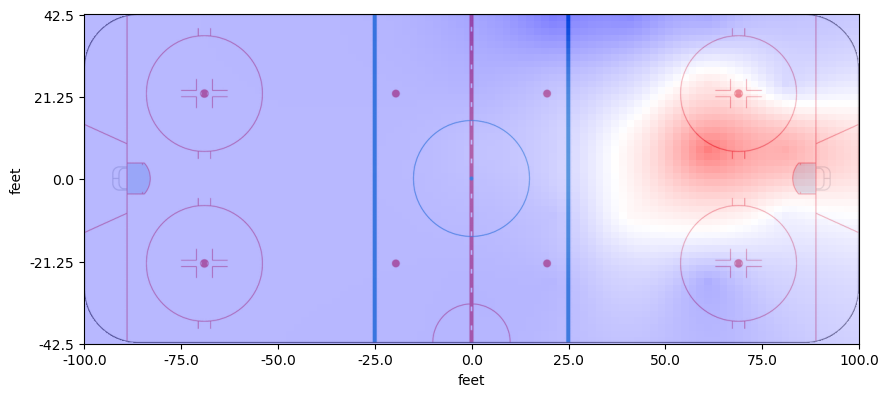

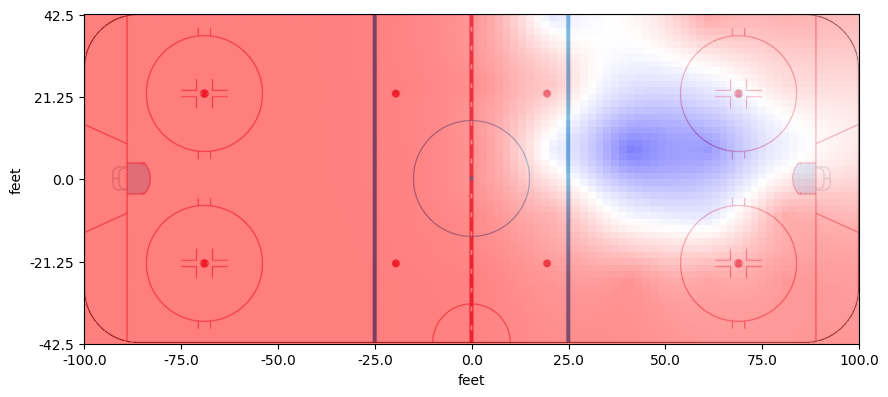

In [75]:
viz = AdvancedViz()
team = "Colorado Avalanche"
viz.draw_heatmap(team, 2016)
viz.draw_heatmap(team, 2020)